## 1. Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import os
import time
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.metrics import CategoricalAccuracy

2025-05-14 14:09:37.617881: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747231777.882089      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747231777.955173      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


beh, library-nya se-abrek

## 2. Import Data

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/triangle/triangle.csv


In [3]:
df=pd.read_csv("/kaggle/input/triangle/triangle.csv")

## 3. Buat Kolom ttg Sudut (Menggunakan Hukum Cosinus)

Definisikan nilai sisi ke dlm suatu variabel

In [4]:
a = df['side1'].values
b = df['side2'].values
c = df['side3'].values

Hitung cosinus sudut (pakai np.clip untuk mencegah domain error)

In [5]:
cos_C = np.clip((a**2 + b**2 - c**2) / (2*a*b), -1.0, 1.0)
cos_B = np.clip((a**2 + c**2 - b**2) / (2*c*a), -1.0, 1.0)
cos_A = np.clip((c**2 + b**2 - a**2) / (2*c*b), -1.0, 1.0)

Hitung sudut dalam radian

In [6]:
angle_A_rad = np.arccos(cos_A)
angle_B_rad = np.arccos(cos_B)
angle_C_rad = np.arccos(cos_C)

Konversi ke derajat

In [7]:
angle_A_deg = np.degrees(angle_A_rad)
angle_B_deg = np.degrees(angle_B_rad)
angle_C_deg = np.degrees(angle_C_rad)

Buat kolom yang berisi nilai derajat

In [8]:
df['angle1'] = angle_A_deg
df['angle2'] = angle_B_deg
df['angle3'] = angle_C_deg

Cek kelas baru

In [9]:
print(df['angle_type'].value_counts())
print(df['side_type'].value_counts())
print(df.head())

angle_type
acute          1555
right          1257
equiangular    1226
obtuse          962
Name: count, dtype: int64
side_type
scalene        2513
isosceles      1261
equilateral    1226
Name: count, dtype: int64
   side1  side2  side3    side_type   angle_type     angle1      angle2  \
0      1      1      1  equilateral  equiangular  60.000000   60.000000   
1     15      8     17      scalene        right  61.927513   28.072487   
2     10     10     10  equilateral  equiangular  60.000000   60.000000   
3     10     17     10    isosceles       obtuse  31.788331  116.423339   
4      4      3      5      scalene        right  53.130102   36.869898   

      angle3  
0  60.000000  
1  90.000000  
2  60.000000  
3  31.788331  
4  90.000000  


## 4. Split Data (70/15/15)

Jadi, sebelum melakukan training, preprocessing, atau apapun itu, data harus dibagi terlebih dahulu. Karena untuk mencegah terjadinya kebocoran data ke algoritma training

In [10]:
#Pilih fitur (Ini pekerjaan paling obvious yagesya)
features = df[['side1', 'side2', 'side3', 'angle1', 'angle2', 'angle3']]

Di sini, kita siapkan tergetnya dulu. Target adalah kedua tipe (kita akan handle sebagai dictionary atau tuple nanti saat melatih)

In [11]:
target_side = df['side_type']
target_angle = df['angle_type']

Setelah itu, kita akan melakukan split pada data. Dalam kasus ini, aku akan split data menjadi 3 bagian [Train (70%), Validation (15%). dan Test (15%)]. Pembagian data akan dilakukan dalam tahap berikut:

1. Data (100%) --> Train (70%) dan Temp(30%)
2. Temp (30%) --> Validation (15%) dan Test(15%)

### Split Pertama

In [12]:
X_train, X_temp, y_train_side, y_temp_side, y_train_angle, y_temp_angle = train_test_split(features, target_side, target_angle, test_size=0.30, random_state=133, stratify=target_side)

### Split Kedua

In [13]:
X_val, X_test, y_val_side, y_test_side, y_val_angle, y_test_angle = train_test_split(X_temp, y_temp_side, y_temp_angle, test_size=0.50, random_state=42, stratify=y_temp_side)

In [14]:
#Cek ukuran hasil split
print("Ukuran X_train:", X_train.shape)
print("Ukuran X_val:", X_val.shape)
print("Ukuran X_test:", X_test.shape)
print("\nUkuran y_train_side:", y_train_side.shape)
print("Ukuran y_val_side:", y_val_side.shape)
print("Ukuran y_test_side:", y_test_side.shape)
print("\nUkuran y_train_angle:", y_train_angle.shape)
print("Ukuran y_val_angle:", y_val_angle.shape)
print("Ukuran y_test_angle:", y_test_angle.shape)

Ukuran X_train: (3500, 6)
Ukuran X_val: (750, 6)
Ukuran X_test: (750, 6)

Ukuran y_train_side: (3500,)
Ukuran y_val_side: (750,)
Ukuran y_test_side: (750,)

Ukuran y_train_angle: (3500,)
Ukuran y_val_angle: (750,)
Ukuran y_test_angle: (750,)


## 4. Scaling

Di sini, aku akan gunakan standard scaler

In [15]:
#Definisikan oknum scaler
scaler = StandardScaler()

#Lakukan "scaling" hanya pada data training
scaler.fit(X_train)

#Terapin semua scaling kepada tiga set yang sudah dibagi: train, validation, dan test
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [16]:
#Cek hasil scaling
print("Data Training Sebelum Scaling (contoh):\n", X_train.head())
print("\nData Training Setelah Scaling (contoh):\n", X_train_scaled[:5])

Data Training Sebelum Scaling (contoh):
       side1  side2  side3     angle1     angle2      angle3
3110      2      3      4  28.955024  46.567463  104.477512
403       8     16     19  24.558212  56.225822   99.215966
3407     13     14     14  55.328009  62.335996   62.335996
2003     13      9      9  92.476515  43.761743   43.761743
1390     12     12      3  82.819244  82.819244   14.361512

Data Training Setelah Scaling (contoh):
 [[-1.75038264 -1.56663627 -1.37374838 -1.272718   -0.56625381  1.8073051 ]
 [-0.59755105  0.91809429  1.48595781 -1.45825466 -0.17246132  1.59142618]
 [ 0.36314195  0.53582805  0.53272241 -0.15983084  0.07666387  0.07825742]
 [ 0.36314195 -0.41983755 -0.42051299  1.40776173 -0.68064921 -0.68383591]
 [ 0.17100335  0.15356181 -1.56439546  1.00024426  0.9118109  -1.89011432]]


Udah bener yagesya. Sekarang lanjut ke metode encoding

## 5. One-Hot Encoding

In [17]:
#Buat oknum encodingnya
encoder_side = OneHotEncoder(sparse_output=False)

### Encoding untuk target 'triangle_type' (Sisi)

In [18]:
#Fit encoder HANYA pada data training target sisi (y_train_side)
#Encoder perlu ditata ulang karena encoder cuma nerima input 2D
y_train_side_reshaped = np.array(y_train_side).reshape(-1, 1)
y_val_side_reshaped = np.array(y_val_side).reshape(-1, 1)
y_test_side_reshaped = np.array(y_test_side).reshape(-1, 1)

encoder_side.fit(y_train_side_reshaped)

OneHotEncoder(sparse_output=False)

In [19]:
#Terapkan encoding ke semua set target sisi
y_train_side_encoded = encoder_side.transform(y_train_side_reshaped)
y_val_side_encoded = encoder_side.transform(y_val_side_reshaped)
y_test_side_encoded = encoder_side.transform(y_test_side_reshaped)

### Encoding untuk target 'angle_type' (Sudut)

In [20]:
#Buat objek OneHotEncoder baru
encoder_angle = OneHotEncoder(sparse_output=False)

In [21]:
#Fit encoder HANYA pada data training target sudut (y_train_angle)
y_train_angle_reshaped = np.array(y_train_angle).reshape(-1, 1)
y_val_angle_reshaped = np.array(y_val_angle).reshape(-1, 1)
y_test_angle_reshaped = np.array(y_test_angle).reshape(-1, 1)

encoder_angle.fit(y_train_angle_reshaped)

OneHotEncoder(sparse_output=False)

In [22]:
#Terapkan encoding ke semua set target sudut
y_train_angle_encoded = encoder_angle.transform(y_train_angle_reshaped)
y_val_angle_encoded = encoder_angle.transform(y_val_angle_reshaped)
y_test_angle_encoded = encoder_angle.transform(y_test_angle_reshaped)

In [23]:
#Cek hasil encoding
print("\nContoh y_train_side asli:", y_train_side[:5].values)
print("Contoh y_train_side encoded:\n", y_train_side_encoded[:5])

print("\nContoh y_train_angle asli:", y_train_angle[:5].values)
print("Contoh y_train_angle encoded:\n", y_train_angle_encoded[:5])


Contoh y_train_side asli: ['scalene' 'scalene' 'isosceles' 'isosceles' 'isosceles']
Contoh y_train_side encoded:
 [[0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]

Contoh y_train_angle asli: ['obtuse' 'obtuse' 'acute' 'obtuse' 'acute']
Contoh y_train_angle encoded:
 [[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]]


## 6. Deep Learning (Tiati Stress,gw jg hampir gila, ngerjain ini)

### Konfigurasi Eksperimen *(UBAH PARAMETER DI BAGIAN INI YGY)*

In [24]:
EXPERIMENT_PARAMS = {
    'optimizer': 'rmsprop',     # Ganti sesuai kebutuhan: 'adam', 'sgd', 'rmsprop'
    'num_hidden_layers': 1,     # Ganti sesuai kebutuhan: 0, 1, 2, ...
    'neurons_per_layer': 16,    # Ganti sesuai kebutuhan: 8, 16, 32, ...
    'hidden_activation': 'relu',# Ganti sesuai kebutuhan: 'relu', 'sigmoid', 'tanh'
    'output_heads': 'angles'      # Ganti sesuai kebutuhan: 'both', 'sides', 'angles'
}

Pengaturan training

In [25]:
EPOCHS = 50
BATCH_SIZE = 32
PATIENCE = 10
try:
    INPUT_SHAPE = (X_train_scaled.shape[1],) # Tentukan input shape di sini
except NameError:
    print("Error: Pastikan variabel X_train_scaled sudah terdefinisi dari pre-processing!")
    exit()

Penamaan File Output

In [26]:
values = EXPERIMENT_PARAMS.values()
config_str = "_".join(str(v) for v in values)
MODEL_FILENAME = f"best_model_{config_str}.keras"
HISTORY_FILENAME = f"history_{config_str}.pkl"

print(f"--- Memulai Eksperimen Baseline: {config_str} ---")
print(f"Model akan disimpan sebagai: {MODEL_FILENAME}")

--- Memulai Eksperimen Baseline: adam_2_32_relu_both ---
Model akan disimpan sebagai: best_model_adam_2_32_relu_both.keras


### Buat Fungsi Model dari Parameter yang sudah ditentukan sebelumnya :)

In [27]:
def build_flexible_mlp(input_shape, params):
    """Jadi, kita bakal masukin parameter MLP (yang sudah ditentukan pada kode sebelumnya) ke model MLP-nya"""
    num_hidden_layers = params['num_hidden_layers']
    neurons_per_layer = params['neurons_per_layer']
    hidden_activation = params['hidden_activation']
    optimizer_name = params['optimizer']
    output_heads = params['output_heads']

    # Definisikan layer input
    inputs = Input(shape=input_shape, name='input_layer')

    # Definisikan hidden layers
    x = inputs # Jika 0 hidden layer, output langsung dari input
    if num_hidden_layers > 0:
        x = Dense(units=neurons_per_layer, activation=hidden_activation, name='hidden_layer_1')(inputs)
        for i in range(1, num_hidden_layers):
            # Hubungkan output layer sebelumnya ke input layer berikutnya
            x = Dense(units=neurons_per_layer, activation=hidden_activation, name=f'hidden_layer_{i+1}')(x)
            # 'x' sekarang adalah output dari hidden layer terakhir yang dibuat

    # Definisikan layer output (keduanya terhubung ke 'x')
    output_side = Dense(units=3, activation='softmax', name='output_side')(x)
    output_angle = Dense(units=4, activation='softmax', name='output_angle')(x)

    # Siapkan konfigurasi untuk kompilasi berdasarkan output_heads
    if output_heads == 'both':
        outputs = [output_side, output_angle]
        # Loss harus dictionary jika multi-output, key = nama layer output
        loss = {
            'output_side': 'categorical_crossentropy',
            'output_angle': 'categorical_crossentropy'
        }
        # Metrics juga dictionary jika ingin melacak per output
        # Menggunakan objek eksplisit bisa lebih jelas, tapi string 'accuracy' biasanya cukup
        metrics = {
            'output_side': CategoricalAccuracy(name='side_accuracy'), # Nama eksplisit
            'output_angle': CategoricalAccuracy(name='angle_accuracy') # Nama eksplisit
            # Alternatif: metrics = {'output_side': 'accuracy', 'output_angle': 'accuracy'}
        }
        print("Konfigurasi Kompilasi: Output SISI dan SUDUT (3 kelas).")
    elif output_heads == 'sides':
        outputs = output_side
        loss = 'categorical_crossentropy'
        metrics = [CategoricalAccuracy(name='side_accuracy')] # Atau ['accuracy']
        print("Konfigurasi Kompilasi: Output SISI saja.")
    elif output_heads == 'angles':
        outputs = output_angle
        loss = 'categorical_crossentropy'
        metrics = [CategoricalAccuracy(name='angle_accuracy')] # Atau ['accuracy']
        print("Konfigurasi Kompilasi: Output SUDUT (3 kelas) saja.")
    else:
        raise ValueError(f"Konfigurasi 'output_heads' ('{output_heads}') tidak valid. Harus 'both', 'sides', atau 'angles'.")

    # Bangun model menggunakan Functional API
    # Memberi nama model berdasarkan parameter bisa membantu identifikasi
    config_str_name = "_".join([f"{k}-{v}" for k, v in params.items()])
    model = Model(inputs=inputs, outputs=outputs, name=f'mlp_{config_str_name}')

    # Kompilasi model - Langkah ini penting untuk mendaftarkan loss dan metrics
    # Keras menggunakan informasi ini saat training dan evaluasi
    model.compile(optimizer=optimizer_name,
                  loss=loss,
                  metrics=metrics)
    model.summary()
    return model

### Persiapan Training

Buat Callbacks

***Callbacks** adalah sebuah sistem untuk menghentikan proses training bila loss yang didapatkan, sudah tidak bisa lebih kecil lagi*

In [28]:
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint(filepath=MODEL_FILENAME, save_weights_only=False,
                                   monitor='val_loss', mode='min', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

Panggil fungsi yang sudah didefinisikan di kode sebelumnya

In [29]:
model = build_flexible_mlp(input_shape=INPUT_SHAPE, params=EXPERIMENT_PARAMS)

Konfigurasi Kompilasi: Output SISI dan SUDUT (3 kelas).


2025-05-14 14:09:54.644458: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "mlp_optimizer-adam_num_hidden_layers-2_neurons_per_layer-32_hidden_activation-relu_output_heads-both"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 6)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ hidden_layer_1 (Dense)    │ (None, 32)             │            224 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ hidden_layer_2 (Dense)    │ (None, 32)             │          1,056 │ hidden_layer_1[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_side (Dense)       │ (None, 3)              │             99 │ hidden_layer_2[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_angle (Dense)      │ (None, 4)              │            132 │ hidden_layer_2[0][0]   │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,511 (5.90 KB)

 Trainable params: 1,511 (5.90 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
output_heads = EXPERIMENT_PARAMS['output_heads']
if output_heads == 'both':
    y_train_target = {'output_side': y_train_side_encoded, 'output_angle': y_train_angle_encoded}
    y_val_target = {'output_side': y_val_side_encoded, 'output_angle': y_val_angle_encoded}
elif output_heads == 'sides':
    y_train_target = y_train_side_encoded
    y_val_target = y_val_side_encoded
elif output_heads == 'angles':
    y_train_target = y_train_angle_encoded
    y_val_target = y_val_angle_encoded

### TRAINING MODEL

In [31]:
start_time = time.time()
history = None
try:
    history = model.fit(
        x=X_train_scaled,
        y=y_train_target,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_val_scaled, y_val_target),
        callbacks=callbacks_list,
        sample_weight=None,
        shuffle=True,
        verbose=1
    )
    training_time = time.time() - start_time
    print(f"Pelatihan selesai dalam {training_time:.2f} detik.")

#Ini adalah fungsi penangkal error. kalo gaada, juga gapapa. tp klo ada, akan jauh lebih nyaman
except Exception as e:
    training_time = time.time() - start_time
    print(f"\n***** ERROR SAAT TRAINING ({training_time:.2f} detik) *****: {e}")
    history = None

Epoch 1/50
103/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2607 - output_angle_angle_accuracy: 0.4344 - output_angle_loss: 1.2886 - output_side_loss: 0.9721 - output_side_side_accuracy: 0.5572
Epoch 1: val_loss improved from inf to 1.82755, saving model to best_model_adam_2_32_relu_both.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 2.2485 - output_angle_angle_accuracy: 0.4421 - output_angle_loss: 1.2823 - output_side_loss: 0.9662 - output_side_side_accuracy: 0.5600 - val_loss: 1.8275 - val_output_angle_angle_accuracy: 0.5813 - val_output_angle_loss: 1.0766 - val_output_side_loss: 0.7549 - val_output_side_side_accuracy: 0.7320
Epoch 2/50
108/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6978 - output_angle_angle_accuracy: 0.6626 - output_angle_loss: 0.9880 - output_side_loss: 0.7098 - output_side_side_accuracy: 0.7440
Epoch 2: val_loss improved from 1.82755 to 1.41345, saving model to best_model_adam_2_32_relu_both.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.69

## 7. Evaluasi Model Deep Learning (Bagian ini lebih kematian lagi 💀💀💀)

### Cek dan Load model hasil training sebelumnya

In [32]:
print(f"\n--- Mengevaluasi Model (Tanpa 'Right'): {config_str} ---")
evaluation_summary = {} # Untuk menyimpan hasil .evaluate()

if not os.path.exists(MODEL_FILENAME):
    print(f"Error: File model terbaik {MODEL_FILENAME} tidak ditemukan.")
    # Mungkin keluar atau set evaluation_summary ke None
    evaluation_summary = None
else:
    print(f"Memuat model terbaik dari: {MODEL_FILENAME}")
    loaded_model = tf.keras.models.load_model(MODEL_FILENAME)


--- Mengevaluasi Model (Tanpa 'Right'): adam_2_32_relu_both ---
Memuat model terbaik dari: best_model_adam_2_32_relu_both.keras


### Siapkan Target Test untuk .evaluate()

In [33]:
        if output_heads == 'both':
            y_test_target_eval = {'output_side': y_test_side_encoded, 'output_angle': y_test_angle_encoded}
        elif output_heads == 'sides':
            y_test_target_eval = y_test_side_encoded
        elif output_heads == 'angles':
            y_test_target_eval = y_test_angle_encoded
        else: # Kasus tidak valid
             raise ValueError("output_heads tidak valid saat menyiapkan target evaluasi.")

### Prediksi pada Test Set

In [34]:
        print("Membuat prediksi dengan model.predict()...")
        predictions = loaded_model.predict(X_test_scaled)

Membuat prediksi dengan model.predict()...
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


### Proses Prediksi & Analisis Detail


Memulai evaluasi untuk model: best_model_adam_2_32_relu_both.keras
Konfigurasi output yang dievaluasi: both
Nama eksperimen untuk laporan: adam_2_32_relu_both

--- Mengevaluasi Model: best_model_adam_2_32_relu_both.keras (Eksperimen: adam_2_32_relu_both) ---
Model best_model_adam_2_32_relu_both.keras berhasil dimuat.

Mengevaluasi dengan model.evaluate()...
  DEBUG: loaded_model.metrics_names -> ['loss', 'compile_metrics', 'output_side_loss', 'output_angle_loss']
  DEBUG: eval_metrics_list (nilai mentah) -> [0.12548628449440002, 0.04791395738720894, 0.07820283621549606, 0.9693333506584167, 0.9906666874885559]
  INFO: Nilai untuk 'Test_Angle_Loss' (0.047914) diambil dari metrik Keras bernama 'compile_metrics'.
  INFO: Nilai untuk 'Test_Angle_Accuracy' (0.969333) diambil dari metrik Keras bernama 'output_angle_loss' yang seharusnya akurasi.

  Hasil .evaluate() (setelah interpretasi):
    Test_Total_Loss: 0.125486
    Test_Angle_Loss: 0.047914
    Test_Side_Loss: 0.078203
    Test_Angle

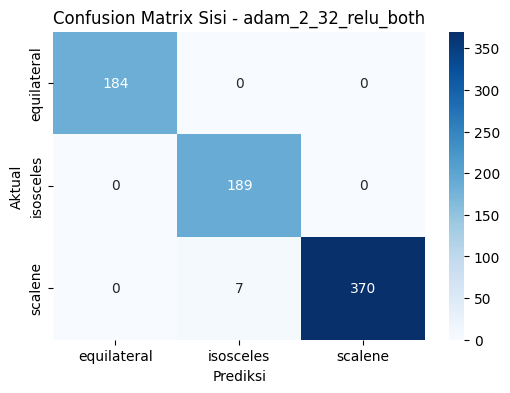


--- Analisis Detail: Output SUDUT ---
  Classification Report (Sudut):
              precision    recall  f1-score   support

       acute       1.00      0.95      0.97       239
 equiangular       1.00      1.00      1.00       184
      obtuse       1.00      0.93      0.96       142
       right       0.89      1.00      0.94       185

    accuracy                           0.97       750
   macro avg       0.97      0.97      0.97       750
weighted avg       0.97      0.97      0.97       750


  Confusion Matrix (Sudut):
             acute  equiangular  obtuse  right
acute          226            0       0     13
equiangular      0          184       0      0
obtuse           0            0     132     10
right            0            0       0    185


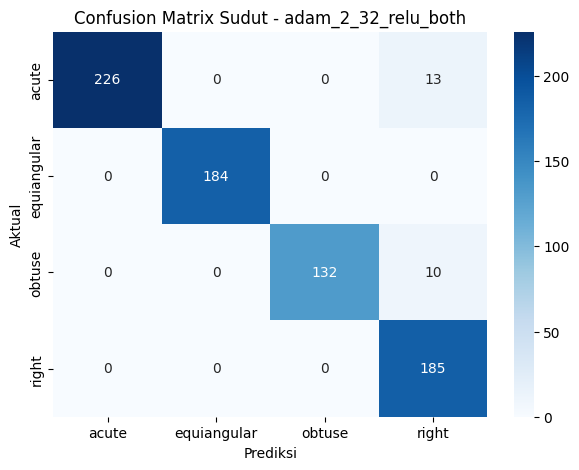



--- Ringkasan Hasil Evaluasi Akhir (dari dictionary) ---
Test_Total_Loss                                                         0.125486
Test_Angle_Loss                                                         0.047914
Test_Side_Loss                                                          0.078203
Test_Angle_Accuracy                                                     0.969333
Test_Side_Accuracy                                                      0.990667
Classification_Report_Sisi                   precision    recall  f1-score   ...
Classification_Report_Sudut                  precision    recall  f1-score   ...


In [35]:
def evaluate_trained_model(model_filename,
                           X_test_scaled,
                           y_test_side_encoded, y_test_angle_encoded, # Target yang sudah di-encode
                           y_test_side_labels, y_test_angle_labels,    # Label asli (string)
                           encoder_side, encoder_angle,
                           output_heads_config, # 'both', 'sides', atau 'angles'
                           experiment_name=""):
    """
    Mengevaluasi model Keras yang sudah disimpan pada test set.

    Args:
        model_filename (str): Path ke file model .keras yang disimpan.
        X_test_scaled (np.ndarray): Fitur test set yang sudah di-scale.
        y_test_side_encoded (np.ndarray): Target sisi test set (one-hot).
        y_test_angle_encoded (np.ndarray): Target sudut test set (one-hot).
        y_test_side_labels (pd.Series or np.ndarray): Label sisi asli test set (string).
        y_test_angle_labels (pd.Series or np.ndarray): Label sudut asli test set (string).
        encoder_side (OneHotEncoder): Encoder yang sudah di-fit untuk sisi.
        encoder_angle (OneHotEncoder): Encoder yang sudah di-fit untuk sudut.
        output_heads_config (str): Konfigurasi output model ('both', 'sides', 'angles').
        experiment_name (str): Nama/Identifier untuk eksperimen (opsional, untuk judul plot).

    Returns:
        dict or None: Dictionary berisi metrik hasil .evaluate() dan info lainnya, atau None jika gagal.
    """
    print(f"\n--- Mengevaluasi Model: {model_filename} (Eksperimen: {experiment_name}) ---")
    evaluation_summary = {} # Inisialisasi di awal

    # 1. Cek dan Load Model
    if not os.path.exists(model_filename):
        print(f"Error: File model {model_filename} tidak ditemukan.")
        evaluation_summary['Error_Loading'] = f"File model {model_filename} tidak ditemukan."
        return evaluation_summary # Kembalikan summary dengan error
    try:
        loaded_model = tf.keras.models.load_model(model_filename)
        print(f"Model {model_filename} berhasil dimuat.")
    except Exception as e:
        print(f"Gagal memuat model {model_filename}. Error: {e}")
        evaluation_summary['Error_Loading'] = f"Gagal memuat model: {e}"
        return evaluation_summary

    # 2. Siapkan Target untuk .evaluate() berdasarkan konfigurasi
    y_test_target_eval = None
    if output_heads_config == 'both':
        y_test_target_eval = {'output_side': y_test_side_encoded, 'output_angle': y_test_angle_encoded}
    elif output_heads_config == 'sides':
        y_test_target_eval = y_test_side_encoded
    elif output_heads_config == 'angles':
        y_test_target_eval = y_test_angle_encoded
    else:
        print(f"Error: Konfigurasi output '{output_heads_config}' tidak valid saat menyiapkan target evaluasi.")
        evaluation_summary['Error_Config'] = f"Konfigurasi output '{output_heads_config}' tidak valid."
        return evaluation_summary

    # =========================================================================
    # 3. Evaluasi dengan .evaluate() DAN PEMETAAN NAMA METRIK YANG LEBIH BAIK
    # =========================================================================
    print("\nMengevaluasi dengan model.evaluate()...")
    try:
        eval_metrics_list = loaded_model.evaluate(X_test_scaled, y_test_target_eval, verbose=0)
        
        # Debugging: Lihat nama metrik mentah dari Keras dan nilainya
        print(f"  DEBUG: loaded_model.metrics_names -> {loaded_model.metrics_names}")
        print(f"  DEBUG: eval_metrics_list (nilai mentah) -> {eval_metrics_list}")

        # Pemetaan nama metrik yang lebih cerdas
        # Indeks 0 selalu total loss
        if len(eval_metrics_list) > 0:
            evaluation_summary['Test_Total_Loss'] = eval_metrics_list[0]

        if output_heads_config == 'both':
            # Urutan yang DIASUMSIKAN berdasarkan observasi perilaku Keras dan outputmu:
            # eval_metrics_list[0]: total_loss (sudah diambil)
            # eval_metrics_list[1]: actual_angle_loss (Keras mungkin menamainya 'compile_metrics' atau 'output_angle_loss')
            # eval_metrics_list[2]: actual_side_loss (Keras mungkin menamainya 'output_side_loss')
            # eval_metrics_list[3]: actual_angle_accuracy (Keras mungkin menamainya 'output_angle_loss' (salah!) atau 'output_angle_angle_accuracy')
            # eval_metrics_list[4]: actual_side_accuracy (Keras mungkin menamainya 'output_side_side_accuracy')

            if len(eval_metrics_list) > 1: # Harus ada angle_loss
                evaluation_summary['Test_Angle_Loss'] = eval_metrics_list[1]
            if len(eval_metrics_list) > 2: # Harus ada side_loss
                evaluation_summary['Test_Side_Loss'] = eval_metrics_list[2]
            if len(eval_metrics_list) > 3: # Harus ada angle_accuracy
                evaluation_summary['Test_Angle_Accuracy'] = eval_metrics_list[3]
            if len(eval_metrics_list) > 4: # Harus ada side_accuracy
                evaluation_summary['Test_Side_Accuracy'] = eval_metrics_list[4]
            
            # Memberikan catatan jika ada nama yang membingungkan dari Keras
            if len(loaded_model.metrics_names) > 1 and loaded_model.metrics_names[1] == 'compile_metrics':
                print(f"  INFO: Nilai untuk 'Test_Angle_Loss' ({eval_metrics_list[1]:.6f}) diambil dari metrik Keras bernama '{loaded_model.metrics_names[1]}'.")
            if len(loaded_model.metrics_names) > 3 and loaded_model.metrics_names[3] == 'output_angle_loss' and eval_metrics_list[3] > 0.5 : # Akurasi > 0.5
                print(f"  INFO: Nilai untuk 'Test_Angle_Accuracy' ({eval_metrics_list[3]:.6f}) diambil dari metrik Keras bernama '{loaded_model.metrics_names[3]}' yang seharusnya akurasi.")

        elif output_heads_config == 'sides':
            # eval_metrics_list[0]: total_loss (juga side_loss)
            # eval_metrics_list[1]: side_accuracy
            if len(eval_metrics_list) > 0: # total_loss juga side_loss
                 evaluation_summary['Test_Side_Loss'] = eval_metrics_list[0]
            if len(eval_metrics_list) > 1:
                evaluation_summary['Test_Side_Accuracy'] = eval_metrics_list[1]

        elif output_heads_config == 'angles':
            # eval_metrics_list[0]: total_loss (juga angle_loss)
            # eval_metrics_list[1]: angle_accuracy
            if len(eval_metrics_list) > 0: # total_loss juga angle_loss
                evaluation_summary['Test_Angle_Loss'] = eval_metrics_list[0]
            if len(eval_metrics_list) > 1:
                evaluation_summary['Test_Angle_Accuracy'] = eval_metrics_list[1]
        
        print("\n  Hasil .evaluate() (setelah interpretasi):")
        for key, value in evaluation_summary.items():
            if "Error" not in key: # Jangan format error
                print(f"    {key}: {value:.6f}")
            else:
                print(f"    {key}: {value}")


    except (ValueError, IndexError, Exception) as e_eval:
        print(f"Error saat menjalankan .evaluate() atau memetakan metrik: {e_eval}")
        evaluation_summary['Error_Evaluating'] = str(e_eval)
        # Jika evaluate gagal total, mungkin tidak ada eval_metrics_list, jadi handle ini
        if 'eval_metrics_list' not in locals() or not eval_metrics_list:
             print("Tidak dapat melanjutkan ke prediksi karena .evaluate() gagal atau tidak menghasilkan data.")
             return evaluation_summary # Kembalikan apa yang sudah ada

    # =========================================================================
    # AKHIR BAGIAN PEMETAAN METRIK
    # =========================================================================

    # 4. Prediksi pada Test Set
    print("\nMembuat prediksi dengan model.predict()...")
    predictions = None
    try:
        predictions = loaded_model.predict(X_test_scaled, verbose=0)
        print("  Prediksi berhasil dibuat.")
    except Exception as e_pred:
        print(f"Error saat menjalankan .predict(): {e_pred}")
        evaluation_summary['Error_Predicting'] = str(e_pred)
        return evaluation_summary # Kembalikan hasil sejauh ini jika predict gagal

    # 5. Proses Prediksi dan Analisis Detail
    print("\nMemproses prediksi untuk analisis detail...")
    pred_labels_side, pred_labels_angle = None, None
    try:
        if output_heads_config == 'both':
            if isinstance(predictions, list) and len(predictions) == 2:
                pred_labels_side = encoder_side.inverse_transform(predictions[0]).flatten()
                pred_labels_angle = encoder_angle.inverse_transform(predictions[1]).flatten()
            else:
                print("  Error: Prediksi untuk 'both' tidak dalam format list[2]. Tidak bisa membuat laporan detail.")
                evaluation_summary['Error_Detail_Processing'] = "Format prediksi 'both' salah."
        elif output_heads_config == 'sides':
            pred_labels_side = encoder_side.inverse_transform(predictions).flatten()
        elif output_heads_config == 'angles':
            pred_labels_angle = encoder_angle.inverse_transform(predictions).flatten()

        # Tampilkan Report & Matrix untuk Sisi
        if y_test_side_labels is not None and pred_labels_side is not None:
            print("\n--- Analisis Detail: Output SISI ---")
            side_labels_unique = encoder_side.categories_[0]
            print("  Classification Report (Sisi):")
            report_sisi = classification_report(y_test_side_labels, pred_labels_side, labels=side_labels_unique, target_names=side_labels_unique, zero_division=0)
            print(report_sisi)
            evaluation_summary['Classification_Report_Sisi'] = report_sisi
            
            print("\n  Confusion Matrix (Sisi):")
            cm_sisi = confusion_matrix(y_test_side_labels, pred_labels_side, labels=side_labels_unique)
            cm_df_sisi = pd.DataFrame(cm_sisi, index=side_labels_unique, columns=side_labels_unique)
            print(cm_df_sisi)
            plt.figure(figsize=(6,4))
            sns.heatmap(cm_df_sisi, annot=True, fmt='d', cmap='Blues')
            plt.title(f'Confusion Matrix Sisi - {experiment_name}')
            plt.ylabel('Aktual')
            plt.xlabel('Prediksi')
            plt.show()

        # Tampilkan Report & Matrix untuk Sudut
        if y_test_angle_labels is not None and pred_labels_angle is not None:
            print("\n--- Analisis Detail: Output SUDUT ---")
            angle_labels_unique = encoder_angle.categories_[0]
            print("  Classification Report (Sudut):")
            report_sudut = classification_report(y_test_angle_labels, pred_labels_angle, labels=angle_labels_unique, target_names=angle_labels_unique, zero_division=0)
            print(report_sudut)
            evaluation_summary['Classification_Report_Sudut'] = report_sudut

            print("\n  Confusion Matrix (Sudut):")
            cm_sudut = confusion_matrix(y_test_angle_labels, pred_labels_angle, labels=angle_labels_unique)
            cm_df_sudut = pd.DataFrame(cm_sudut, index=angle_labels_unique, columns=angle_labels_unique)
            print(cm_df_sudut)
            plt.figure(figsize=(7,5))
            sns.heatmap(cm_df_sudut, annot=True, fmt='d', cmap='Blues')
            plt.title(f'Confusion Matrix Sudut - {experiment_name}')
            plt.ylabel('Aktual')
            plt.xlabel('Prediksi')
            plt.show()

    except Exception as e_detail:
        print(f"Error saat memproses prediksi atau menampilkan analisis detail: {e_detail}")
        evaluation_summary['Error_Detail_Processing'] = str(e_detail)

    return evaluation_summary

model_file_to_evaluate=MODEL_FILENAME
output_config_to_evaluate=EXPERIMENT_PARAMS['output_heads']
exp_name_for_evaluation=config_str

print(f"\nMemulai evaluasi untuk model: {model_file_to_evaluate}")
print(f"Konfigurasi output yang dievaluasi: {output_config_to_evaluate}")
print(f"Nama eksperimen untuk laporan: {exp_name_for_evaluation}")


evaluation_results = evaluate_trained_model(
    model_filename=model_file_to_evaluate,
    X_test_scaled=X_test_scaled,
    y_test_side_encoded=y_test_side_encoded,
    y_test_angle_encoded=y_test_angle_encoded,
    y_test_side_labels=y_test_side,         # Label asli string
    y_test_angle_labels=y_test_angle,       # Label asli string
    encoder_side=encoder_side,
    encoder_angle=encoder_angle,
    output_heads_config=output_config_to_evaluate,
    experiment_name=exp_name_for_evaluation
)

# --- Tampilkan Ringkasan Hasil Evaluasi Akhir ---
print("\n\n======================================================")
print("--- Ringkasan Hasil Evaluasi Akhir (dari dictionary) ---")
print("======================================================")
if evaluation_results:
    # Menggunakan pd.Series untuk tampilan yang lebih rapi
    summary_series = pd.Series(evaluation_results)
    # Format angka float menjadi 6 desimal, kecuali untuk string (laporan)
    for idx, val in summary_series.items():
        if isinstance(val, float):
            summary_series[idx] = f"{val:.6f}"
    print(summary_series.to_string())
else:
    print("Evaluasi gagal atau tidak menghasilkan data.")

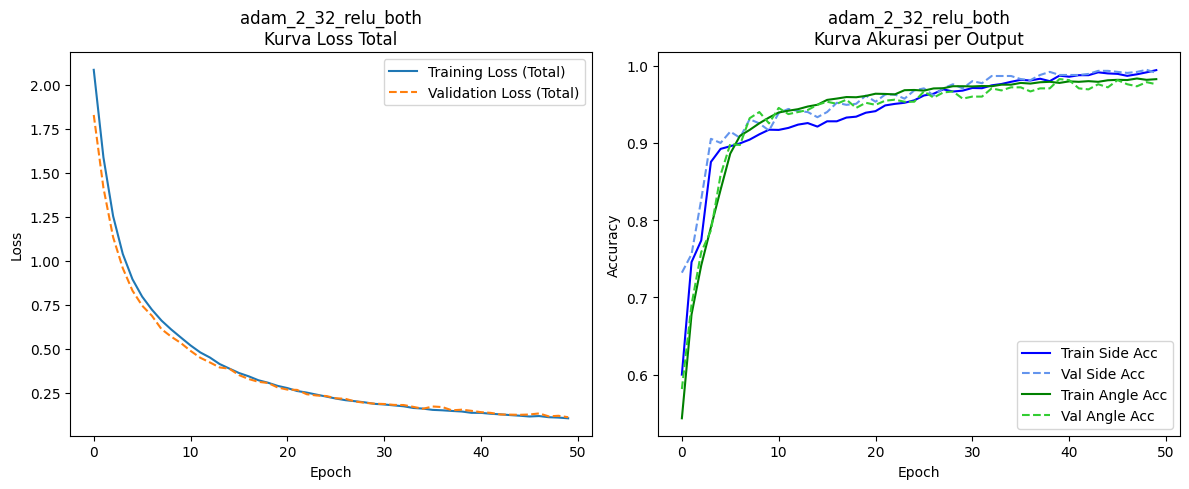

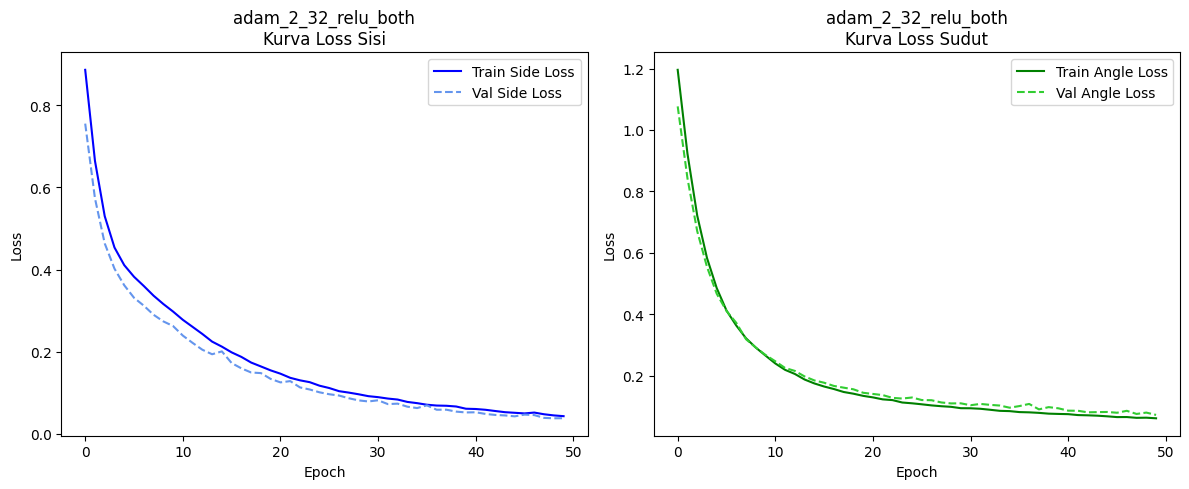

In [36]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_learning_curves(history, output_heads_config, experiment_name=""):
    """
    Menampilkan learning curves (loss dan akurasi) dari history pelatihan.

    Args:
        history (tf.keras.callbacks.History): Objek history dari model.fit().
        output_heads_config (str): Konfigurasi output model ('both', 'sides', 'angles').
        experiment_name (str): Nama eksperimen untuk judul plot (opsional).
    """
    if history is None or not hasattr(history, 'history') or not history.history:
        print("Objek history tidak valid atau kosong. Plotting dilewati.")
        return

    history_df = pd.DataFrame(history.history)
    base_title = f"{experiment_name}\n" if experiment_name else ""

    # --- 1. Plot Total Loss ---
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1) # Plot pertama dalam grid 1x2 untuk Total Loss & Accuracy

    if 'loss' in history_df.columns and 'val_loss' in history_df.columns:
        plt.plot(history_df['loss'], label='Training Loss (Total)')
        plt.plot(history_df['val_loss'], label='Validation Loss (Total)', linestyle='--')
        plt.title(f'{base_title}Kurva Loss Total')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
    else:
        print("Metrik 'loss' atau 'val_loss' tidak ditemukan di history.")

    # --- 2. Plot Accuracy ---
    plt.subplot(1, 2, 2) # Plot kedua dalam grid 1x2
    accuracy_plotted = False

    if output_heads_config == 'both':
        # Coba temukan metrik akurasi untuk 'output_side'
        # Nama metrik Keras: output_layer_name + "_" + metric_object_name
        # Jika CategoricalAccuracy(name='side_accuracy') untuk output_side
        side_acc_key = 'output_side_side_accuracy' # Sesuai model Anda
        val_side_acc_key = f'val_{side_acc_key}'
        if side_acc_key in history_df.columns and val_side_acc_key in history_df.columns:
            plt.plot(history_df[side_acc_key], label='Train Side Acc', color='blue')
            plt.plot(history_df[val_side_acc_key], label='Val Side Acc', linestyle='--', color='cornflowerblue')
            accuracy_plotted = True
        else:
            print(f"Metrik akurasi sisi ('{side_acc_key}') tidak ditemukan.")

        # Coba temukan metrik akurasi untuk 'output_angle'
        angle_acc_key = 'output_angle_angle_accuracy' # Sesuai model Anda
        val_angle_acc_key = f'val_{angle_acc_key}'
        if angle_acc_key in history_df.columns and val_angle_acc_key in history_df.columns:
            plt.plot(history_df[angle_acc_key], label='Train Angle Acc', color='green')
            plt.plot(history_df[val_angle_acc_key], label='Val Angle Acc', linestyle='--', color='limegreen')
            accuracy_plotted = True
        else:
            print(f"Metrik akurasi sudut ('{angle_acc_key}') tidak ditemukan.")
        
        if accuracy_plotted:
            plt.title(f'{base_title}Kurva Akurasi per Output')

    elif output_heads_config == 'sides':
        # Cari 'output_side_side_accuracy' atau 'side_accuracy' atau 'accuracy'
        # Urutan prioritas pencarian:
        side_keys_to_try = ['output_side_side_accuracy', 'side_accuracy', 'accuracy']
        side_acc_key, val_side_acc_key = None, None

        for key_base in side_keys_to_try:
            if key_base in history_df.columns and f'val_{key_base}' in history_df.columns:
                side_acc_key = key_base
                val_side_acc_key = f'val_{key_base}'
                break
        
        if side_acc_key and val_side_acc_key:
            plt.plot(history_df[side_acc_key], label=f'Train Accuracy ({side_acc_key})')
            plt.plot(history_df[val_side_acc_key], label=f'Validation Accuracy ({val_side_acc_key})', linestyle='--')
            plt.title(f'{base_title}Kurva Akurasi Sisi')
            accuracy_plotted = True
        else:
            print(f"Metrik akurasi sisi tidak ditemukan (mencoba: {', '.join(side_keys_to_try)}).")

    elif output_heads_config == 'angles':
        # Cari 'output_angle_angle_accuracy' atau 'angle_accuracy' atau 'accuracy'
        angle_keys_to_try = ['output_angle_angle_accuracy', 'angle_accuracy', 'accuracy']
        angle_acc_key, val_angle_acc_key = None, None

        for key_base in angle_keys_to_try:
            if key_base in history_df.columns and f'val_{key_base}' in history_df.columns:
                angle_acc_key = key_base
                val_angle_acc_key = f'val_{key_base}'
                break

        if angle_acc_key and val_angle_acc_key:
            plt.plot(history_df[angle_acc_key], label=f'Train Accuracy ({angle_acc_key})')
            plt.plot(history_df[val_angle_acc_key], label=f'Validation Accuracy ({val_angle_acc_key})', linestyle='--')
            plt.title(f'{base_title}Kurva Akurasi Sudut')
            accuracy_plotted = True
        else:
            print(f"Metrik akurasi sudut tidak ditemukan (mencoba: {', '.join(angle_keys_to_try)}).")

    if accuracy_plotted:
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
    else: # Jika tidak ada akurasi yang diplot di subplot kedua
        if not ('loss' in history_df.columns and 'val_loss' in history_df.columns): # Jika subplot pertama juga kosong
             plt.close() # Tutup figure jika sama sekali tidak ada yang diplot
        else: # Jika hanya subplot akurasi yang kosong
            fig = plt.gcf()
            fig.delaxes(fig.axes[1]) # Hapus subplot kedua yang kosong
            fig.axes[0].change_geometry(1, 1, 1) # Ubah subplot pertama jadi 1x1

    plt.tight_layout()
    plt.show()


    # --- 3. (Opsional) Plot Loss Individual Jika 'both' ---
    if output_heads_config == 'both':
        plt.figure(figsize=(12, 5))
        individual_loss_plotted = False

        # Plot loss sisi
        plt.subplot(1, 2, 1)
        side_loss_key = 'output_side_loss' # Keras menamai loss individual dengan nama output
        val_side_loss_key = f'val_{side_loss_key}'
        if side_loss_key in history_df.columns and val_side_loss_key in history_df.columns:
            plt.plot(history_df[side_loss_key], label='Train Side Loss', color='blue')
            plt.plot(history_df[val_side_loss_key], label='Val Side Loss', linestyle='--', color='cornflowerblue')
            plt.title(f'{base_title}Kurva Loss Sisi')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            individual_loss_plotted = True
        else:
            print(f"Metrik loss sisi ('{side_loss_key}') tidak ditemukan.")
            # Hapus subplot jika tidak ada data
            fig = plt.gcf(); fig.delaxes(fig.axes[-1])


        # Plot loss sudut
        plt.subplot(1, 2, 2 if individual_loss_plotted else 1) # Sesuaikan posisi subplot
        angle_loss_key = 'output_angle_loss'
        val_angle_loss_key = f'val_{angle_loss_key}'
        if angle_loss_key in history_df.columns and val_angle_loss_key in history_df.columns:
            plt.plot(history_df[angle_loss_key], label='Train Angle Loss', color='green')
            plt.plot(history_df[val_angle_loss_key], label='Val Angle Loss', linestyle='--', color='limegreen')
            plt.title(f'{base_title}Kurva Loss Sudut')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            individual_loss_plotted = True
        else:
            print(f"Metrik loss sudut ('{angle_loss_key}') tidak ditemukan.")
            # Hapus subplot jika tidak ada data
            fig = plt.gcf(); fig.delaxes(fig.axes[-1])
        
        if individual_loss_plotted:
            plt.tight_layout()
            plt.show()
        else: # Jika tidak ada loss individual yang diplot
            plt.close() # Tutup figure jika kosong

history_object_to_plot = history # Ganti dengan objek history yang sesuai
output_config_for_plot = EXPERIMENT_PARAMS['output_heads'] # Ambil dari konfigurasi
experiment_name_for_plot = config_str # Nama konfigurasi eksperimen

# Panggil fungsi plotting:
if 'history_object_to_plot' in locals() and history_object_to_plot is not None:
   plot_learning_curves(history_object_to_plot, output_config_for_plot, experiment_name_for_plot)
else:
   print("Variabel history belum didefinisikan atau None.")